# Fibril Generator and CyRSoXS Simulation

In [4]:
from scipy.interpolate import interp1d
from scipy.ndimage import rotate
from sklearn.preprocessing import normalize
from scipy.ndimage import gaussian_filter
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import trimesh
import os
# import pyembree
import random
import pickle

from Morphology import Morphology
from Fibril import Fibril
import sys
import pathlib


import subprocess
import h5py

from PyHyperScattering.load import cyrsoxsLoader
from PyHyperScattering.integrate import WPIntegrator


import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from matplotlib import cm
from matplotlib.colors import LogNorm

import numpy as np
import io
from PIL import Image
import PIL

import open3d as o3d

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define path to NRSS and PyHyperScattering

In [2]:
sys.path.append('C:/Users/Phong/NRSS/')
from NRSS.writer import write_materials, write_hdf5, write_config, write_slurm
from NRSS.checkH5 import checkH5

## Define and generate fibril morphology

In [3]:
# Declare model box size in nm (x,y,z)
x_dim_nm  = 1024
y_dim_nm  = 1024
z_dim_nm  = 256
pitch_nm = 2 # Dimension of voxel in nm

# Initialize morphology
morphology = Morphology(x_dim_nm, y_dim_nm, z_dim_nm, pitch_nm)
morphology.set_model_parameters(radius_nm_avg = 15,
                                radius_nm_std = 3,
                                max_num_fibrils = 1000,
                                fibril_length_range_nm = [30, 400])

morphology.fill_model(timeout = 60)

Filling model:   2%|█▌                                                               | 24/1000 [00:19<13:25,  1.21it/s]

KeyboardInterrupt



In [ ]:
# May not show if the morphology is too large (too many fibrils)
scene = morphology.get_scene(show_bounding_box=True)
scene.show()

In [ ]:
morphology.plot_fibril_histogram()

In [ ]:
morphology.voxelize_model()

## Save voxelized morphology as reduced morphology

In [ ]:
from ReducedMorphology import ReducedMorphology
rm = ReducedMorphology(morphology)

In [ ]:
rm.pickle()

## Load voxelized reduced morphology

In [5]:
most_recent_file = None
most_recent_mtime = 0

# Iterate through all subdirectories and find the most recently modified .pickle file
for root, dirs, files in os.walk('.'):
    for filename in files:
        if filename.endswith('.pickle') and 'HDF5' not in os.listdir(root):
            full_path = os.path.abspath(os.path.join(root, filename))
            mtime = os.path.getmtime(full_path)
            if mtime > most_recent_mtime:
                most_recent_mtime = mtime
                most_recent_file = full_path

# Load the most recently modified .pickle file
rm = None
if most_recent_file:
    print(f"Loading the most recently modified file: {most_recent_file}")
    with open(most_recent_file, 'rb') as f:
        rm = pickle.load(f)
else:
    print("No pickle files found.")

Loading the most recently modified file: C:\Users\Phong\Box\Research\Mixed Conduction Project\RSOXS Projects\Shared RSoXS Folder\CyRSoXS Processing\DopantModeling-main\1024x1024x256nm_pitch2nm_rad15nm_std3nm_1750fib_30-200nm.pickle


## Create material matricies

In [6]:
from PostProcessing import generate_material_matricies
# Edit post processing parameters in PostProcessing.py
mat_Vfrac, mat_S, mat_theta, mat_psi = generate_material_matricies(rm)

Generating material matrices:  13%|██████▌                                          | 235/1750 [00:24<02:37,  9.63it/s]
Exception ignored in: <function WeakSet.__init__.<locals>._remove at 0x00000256B07E50D0>
Traceback (most recent call last):
  File "C:\Users\Phong\anaconda3\envs\smi_analysis\lib\_weakrefset.py", line 40, in _remove
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
# PostProcessor Setup
post_processor = PostProcessor(
    num_materials=4, dope_type=3, dopant_frac=0.0825, core_shell_morphology=True,
                 gaussian_std=3, fibril_shell_cutoff=0.2, surface_roughness=False, height_feature=3,
                 max_valley_nm=46, amorph_matrix_Vfrac=1, amorphous_orientation=True)



In [ ]:
from PostProcessing import analyze_mol_fractions

VACUUM_ID  = 0 # Vacuum
CRYSTAL_ID = 1 # Crystalline P3HT
AMORPH_ID  = 2 # Amorphous P3HT
DOPANT_ID  = 3 # Dopant (optional)

mol_weight = {
    CRYSTAL_ID: 166.2842, # Molecular weight of crystalline P3HT
    AMORPH_ID: 166.2842,  # Molecular weight of amorphous P3HT
    DOPANT_ID: 280.14     # Molecular weight of TFSI- = 280.14, Molecular weight of F4TCNQ = 276.15
}

density = {
    CRYSTAL_ID: 1.1, # Density of crystalline P3HT
    AMORPH_ID: 1.1,  # Density of amorphous P3HT
    DOPANT_ID: 1.1   # Density of dopant in P3HT
}

[crystalline_mol_fraction, amorphous_mol_fraction, dopant_mol_fraction] = post_processor.analyze_mol_fractions(mat_Vfrac, mol_weight, density)

## Generate simulation input files

In [45]:
phys_size = 2.0

# Get the maximum index based on the length of one of the arrays
max_index = len(mat_Vfrac)

# Create the data structure dynamically
data_to_write = [[mat_Vfrac[i], mat_S[i], mat_theta[i], mat_psi[i]] for i in range(max_index)]

write_hdf5(data_to_write, phys_size, 'Fibril.hdf5'),


--> Marking Fibril.hdf5


('Fibril.hdf5',)

Dataset dimensions (Z, Y, X): 128 x 512 x 512
Number of Materials: 4

Material 1 Vfrac. Min: -5.551115123125783e-17 Max: 1.0
Material 1 S. Min: 0.0 Max: 0.0
Material 1 theta. Min: 0.0 Max: 0.0
Material 1 psi. Min: 0.0 Max: 0.0


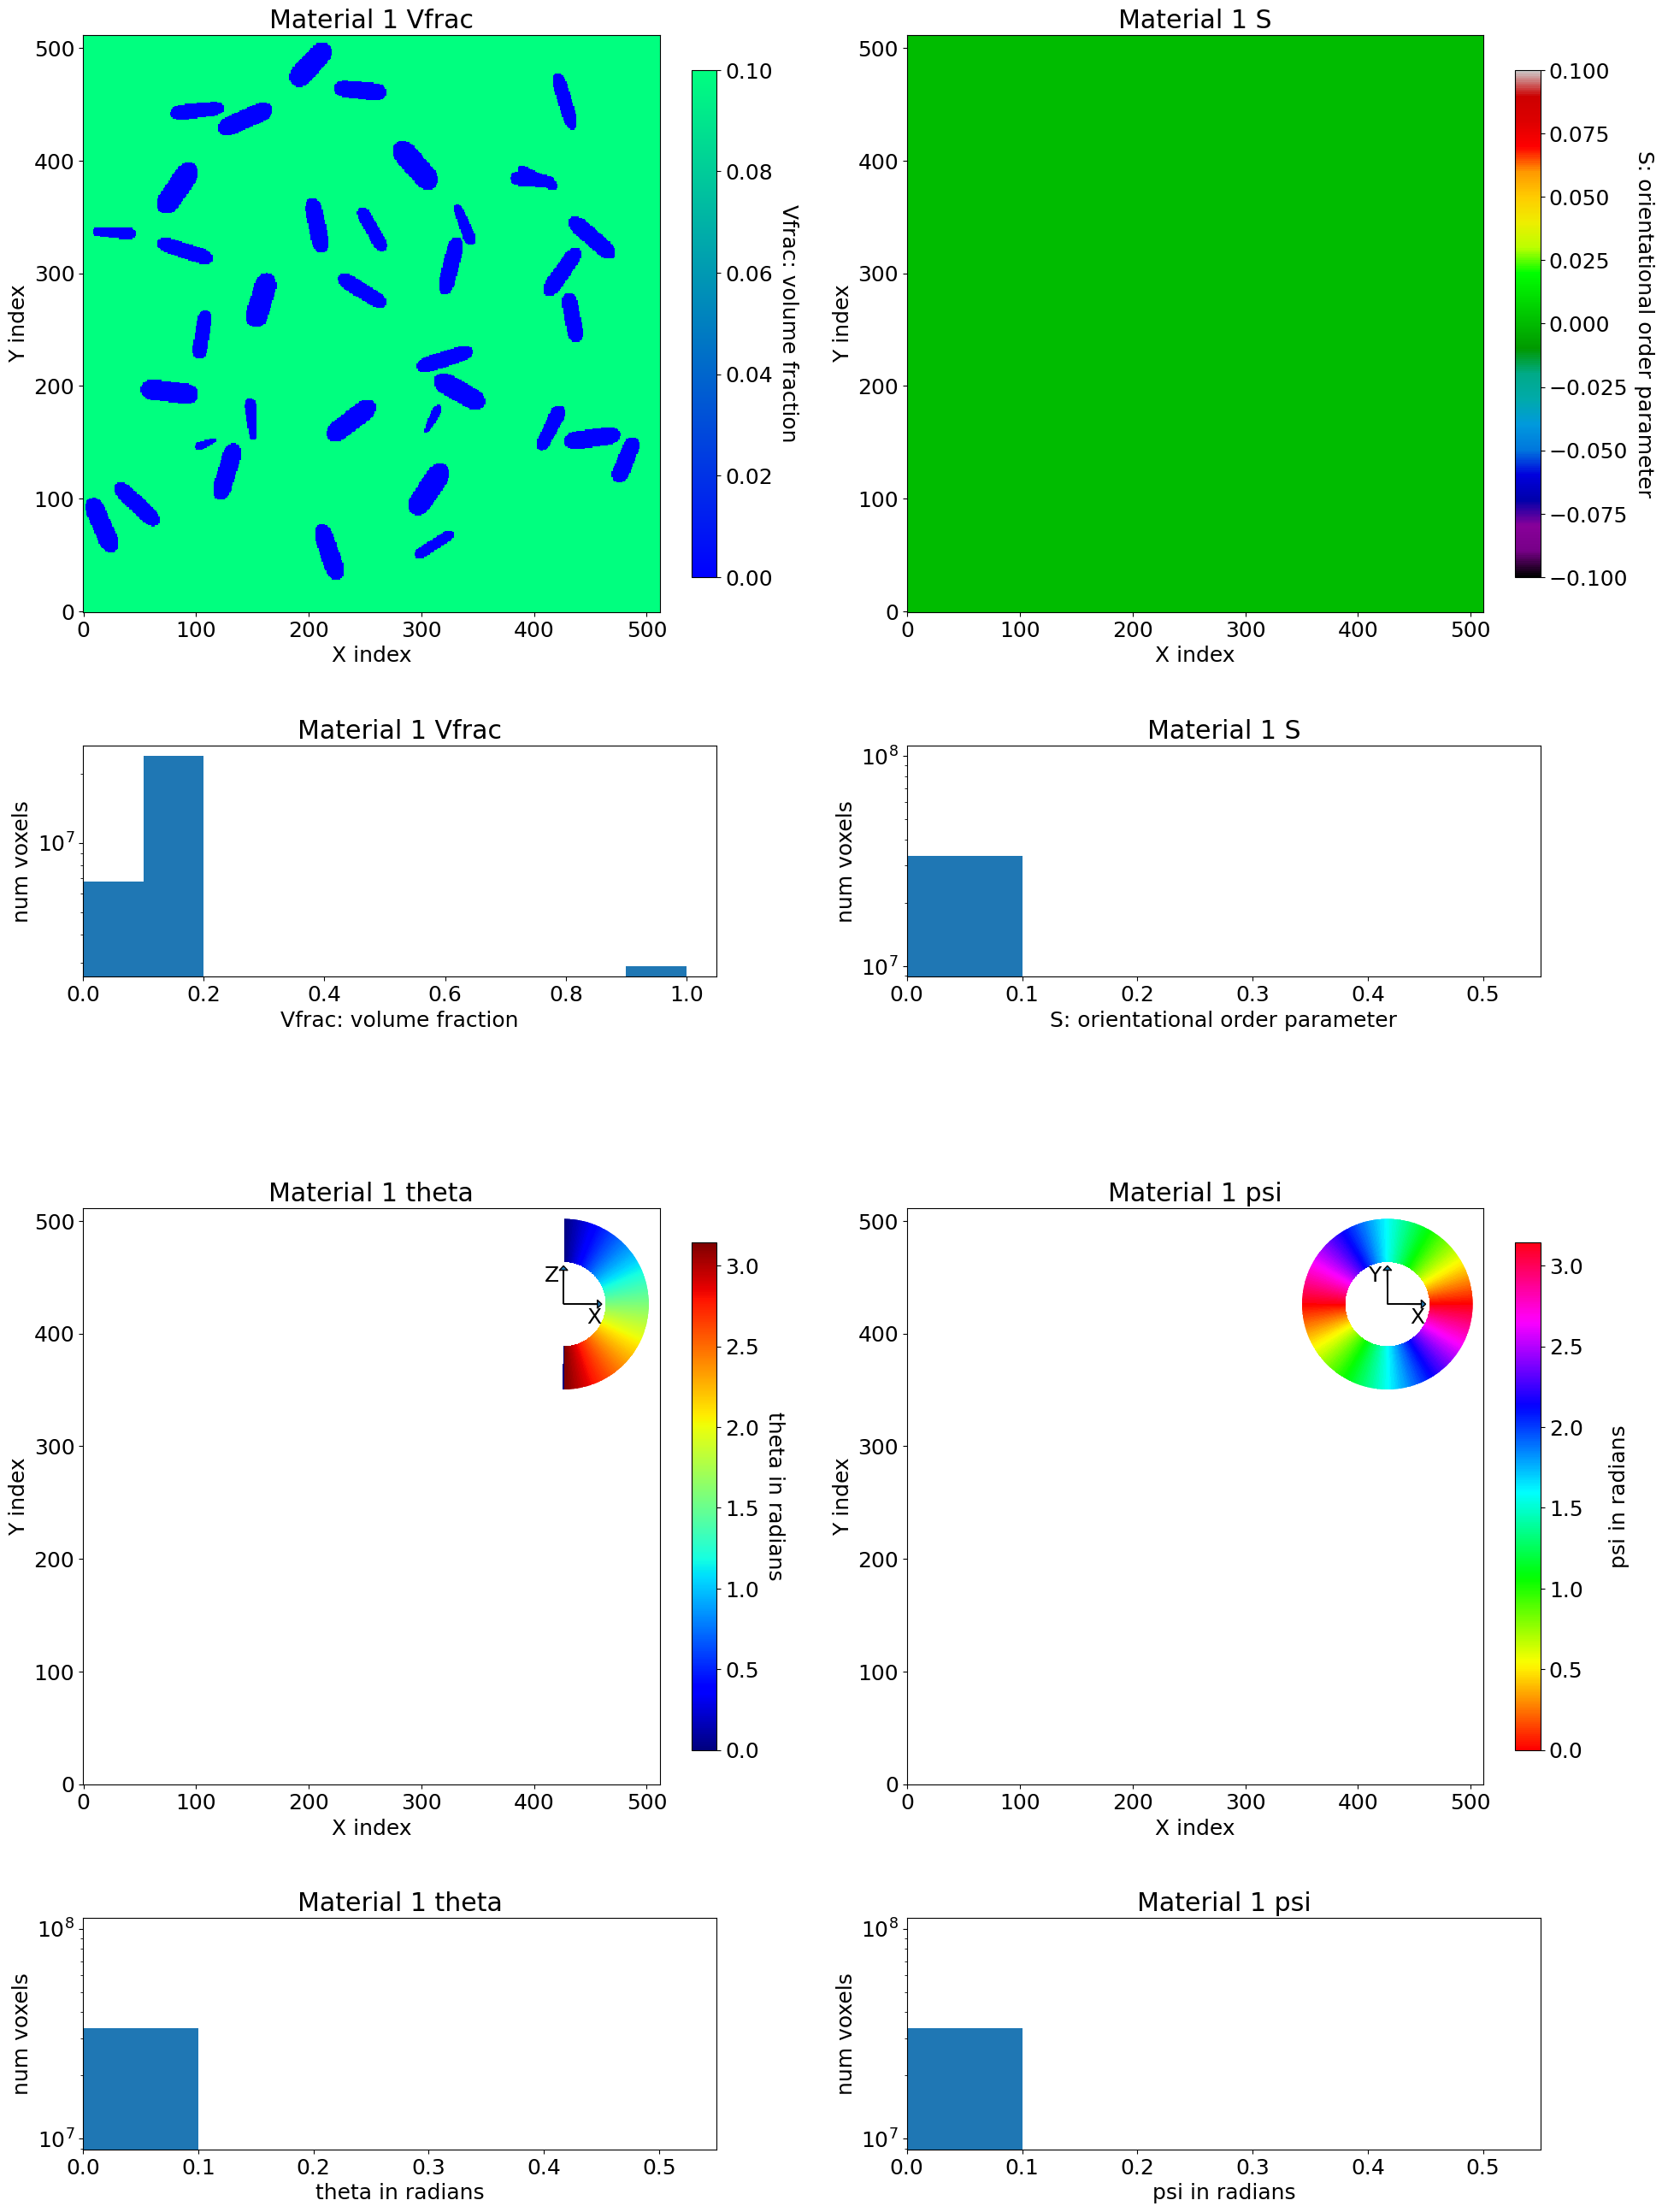

Material 2 Vfrac. Min: 0.0 Max: 0.9999997499297825
Material 2 S. Min: 0.0 Max: 1.0
Material 2 theta. Min: 0.0 Max: 1.6083662510256396
Material 2 psi. Min: 0.0 Max: 3.1196858317484004


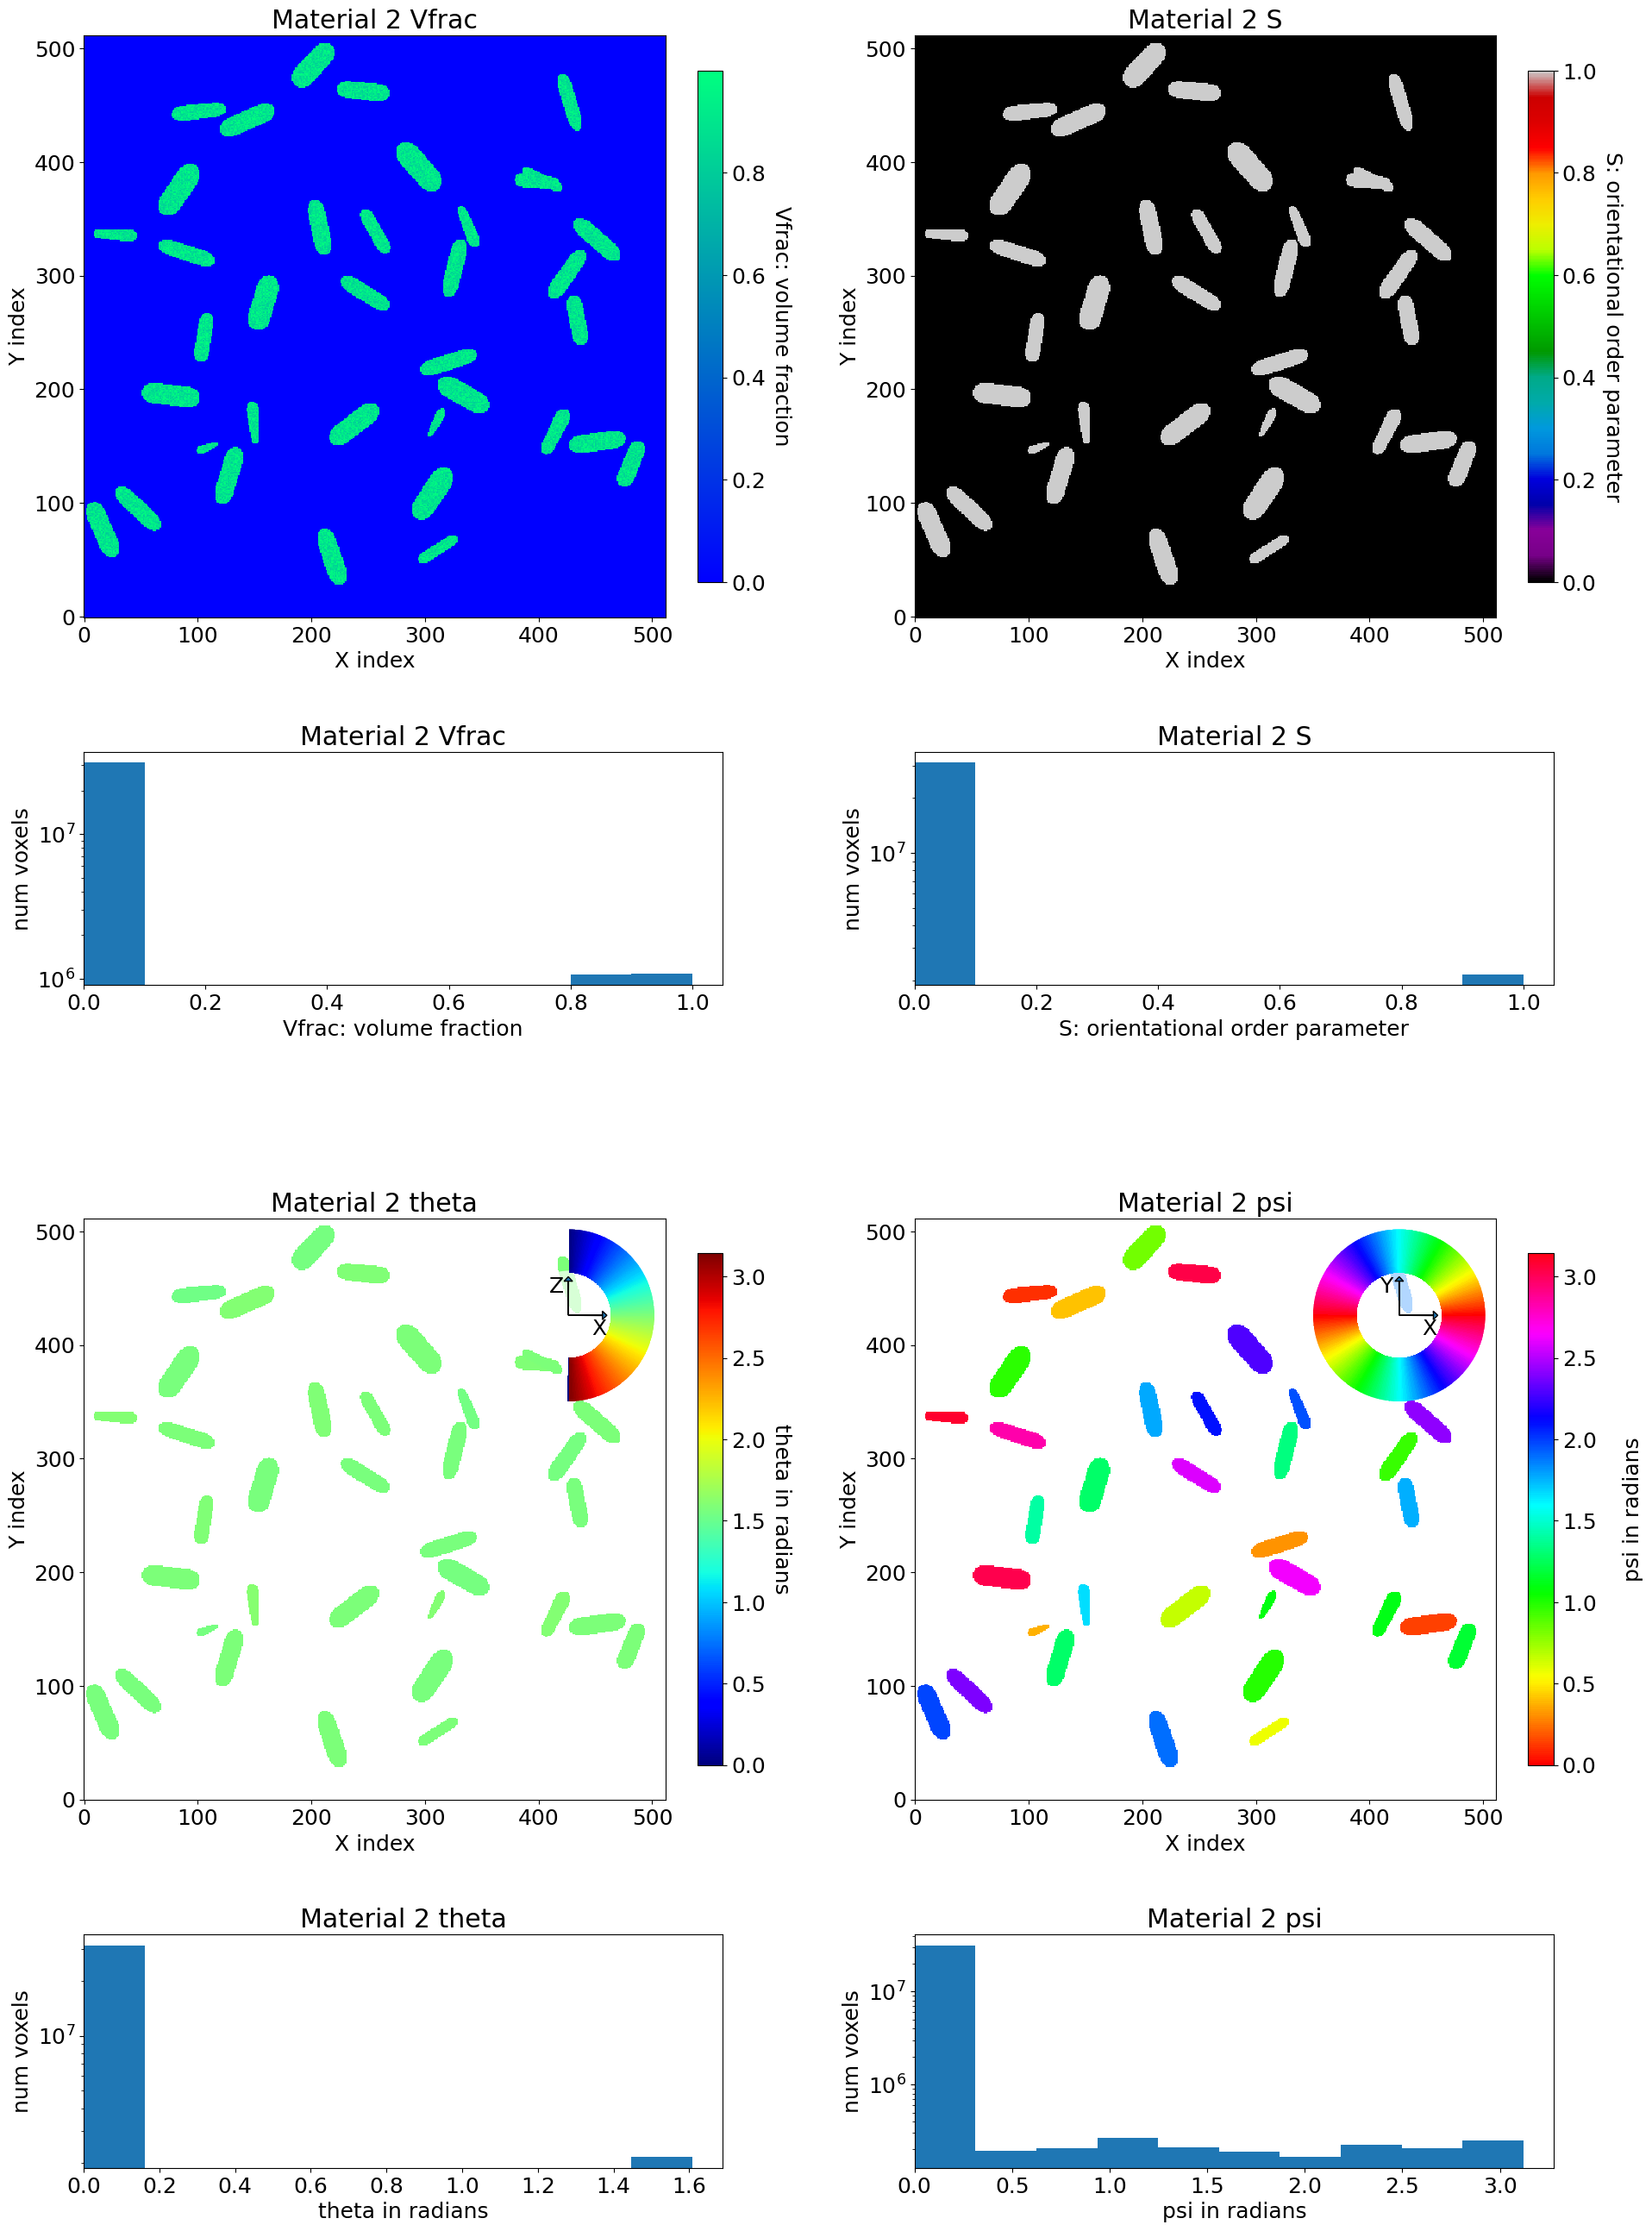

Material 3 Vfrac. Min: 0.0 Max: 0.8999999902947465
Material 3 S. Min: 0.0 Max: 1.0
Material 3 theta. Min: 0.0 Max: 3.140975354916551
Material 3 psi. Min: 0.0 Max: 3.141592535614052


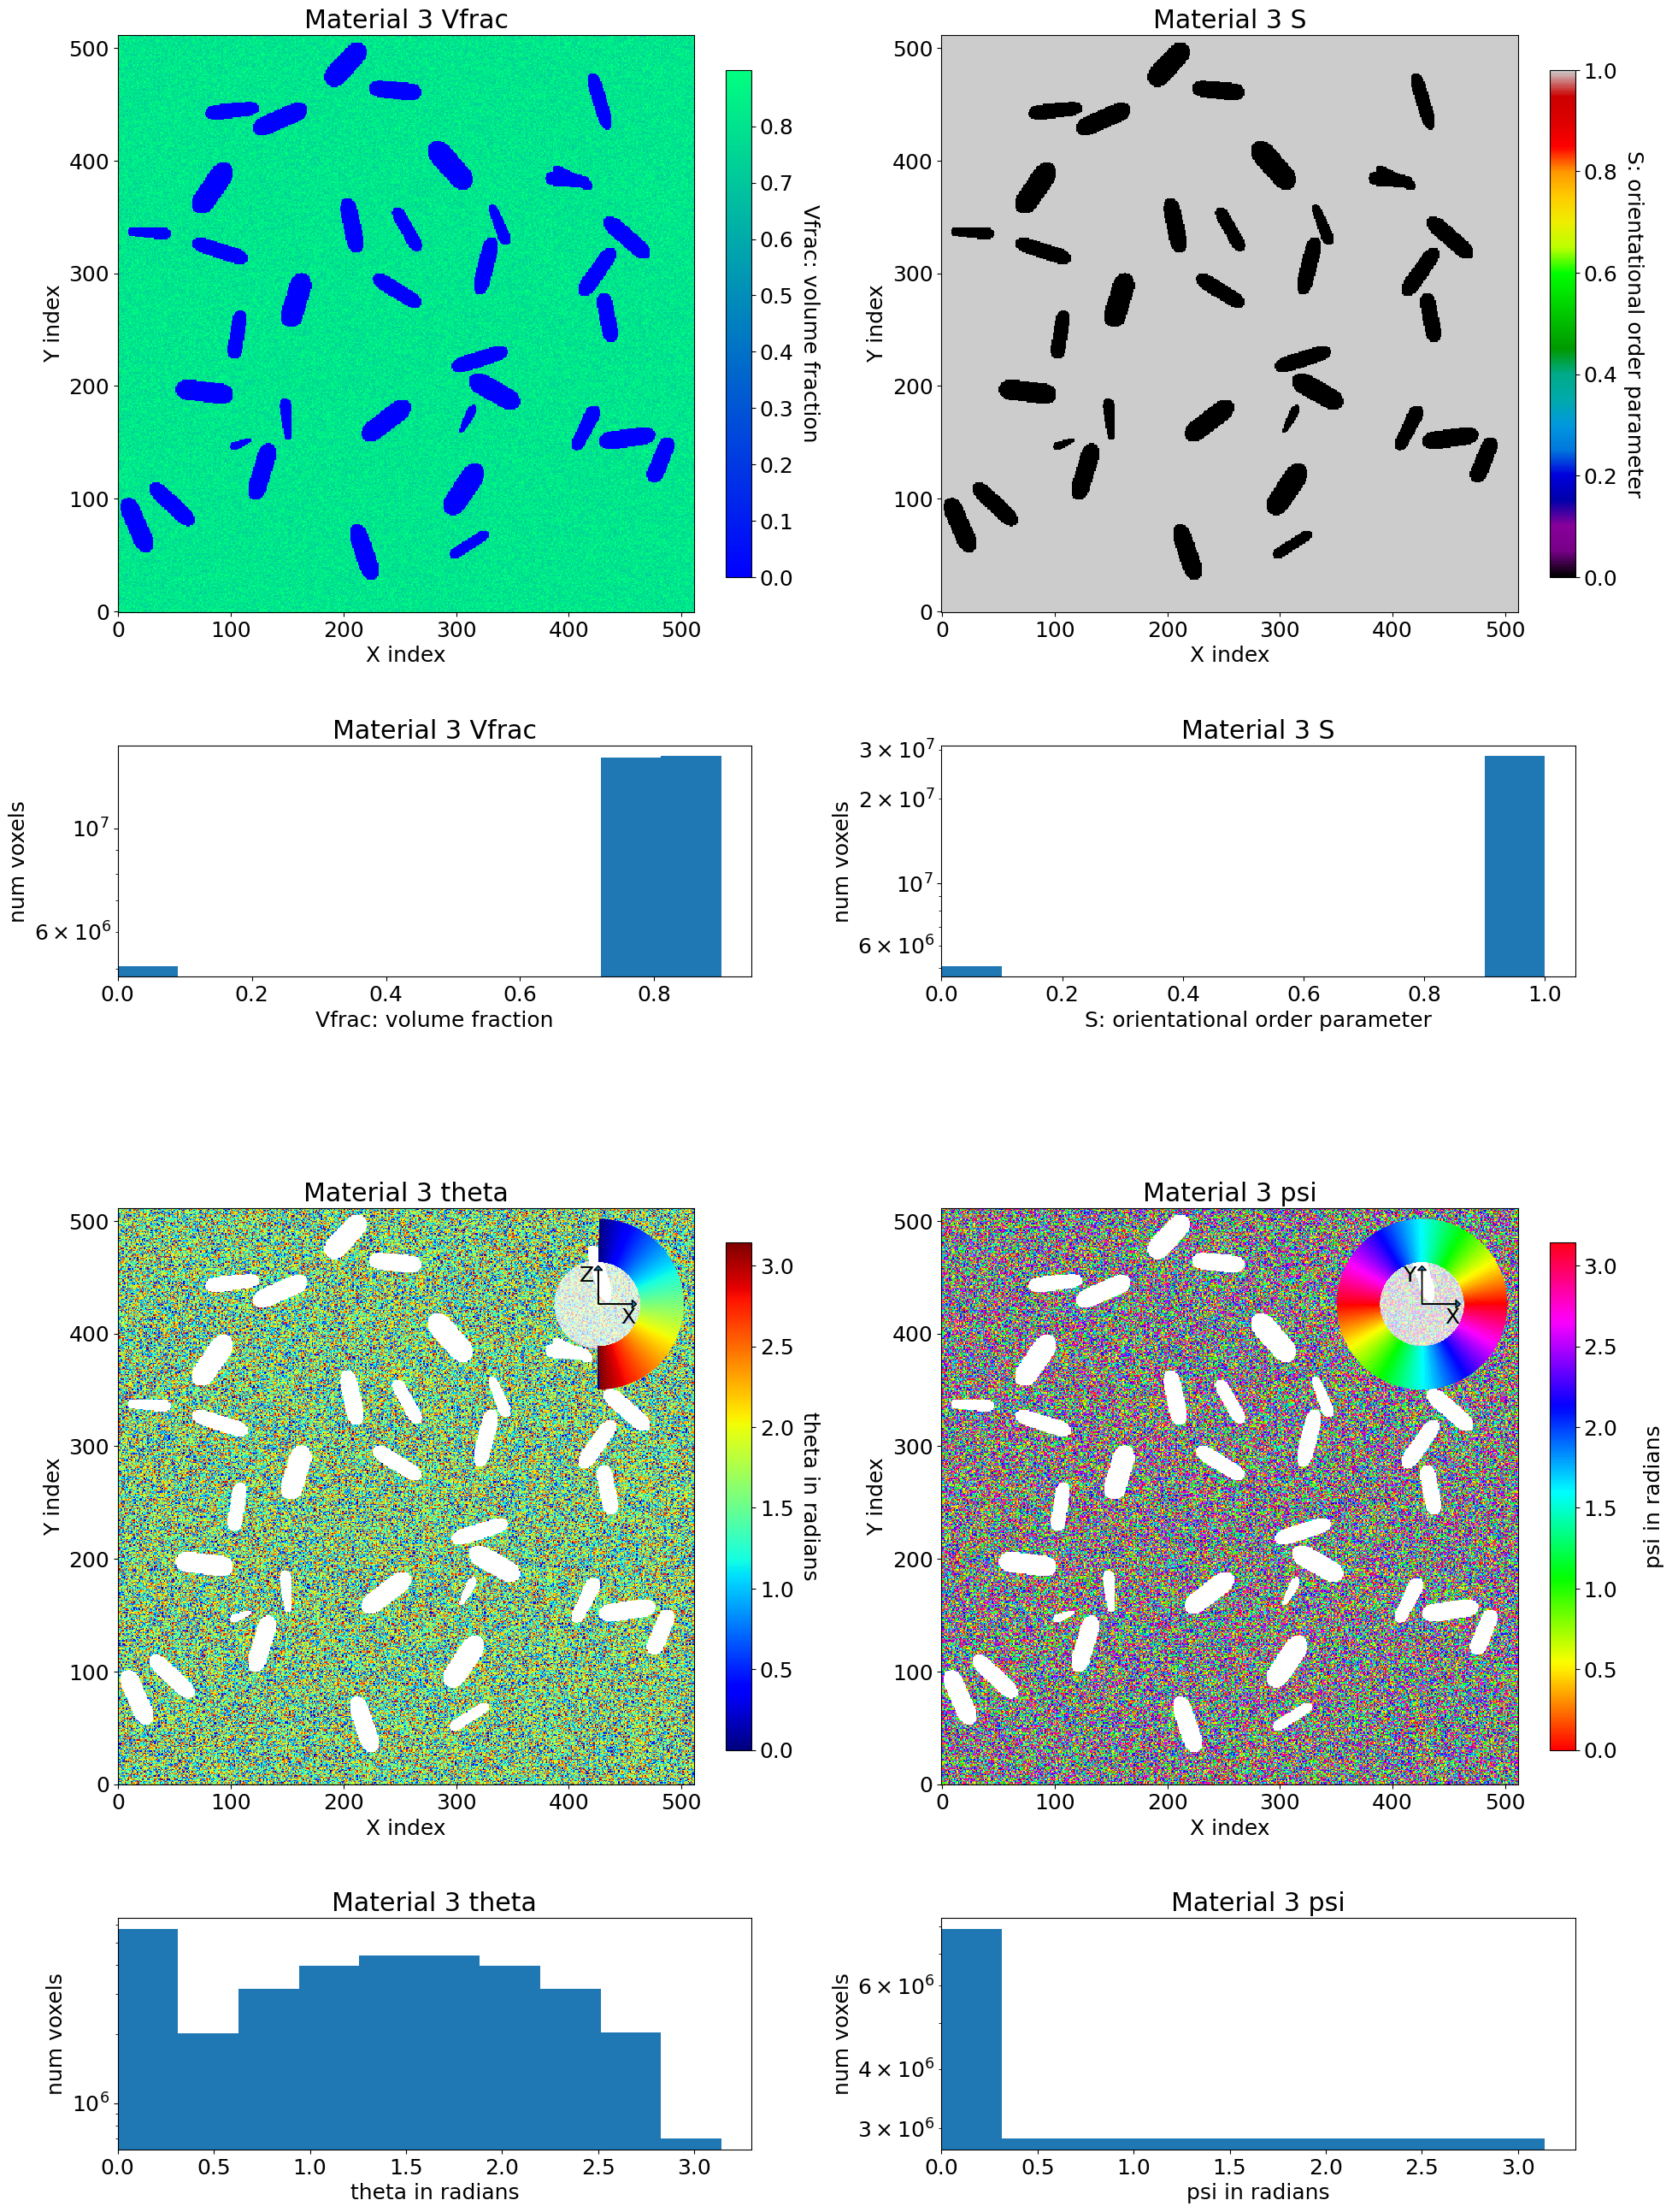

Material 4 Vfrac. Min: 0.0 Max: 0.19919087177969103
Material 4 S. Min: 0.0 Max: 0.0
Material 4 theta. Min: 0.0 Max: 0.0
Material 4 psi. Min: 0.0 Max: 0.0


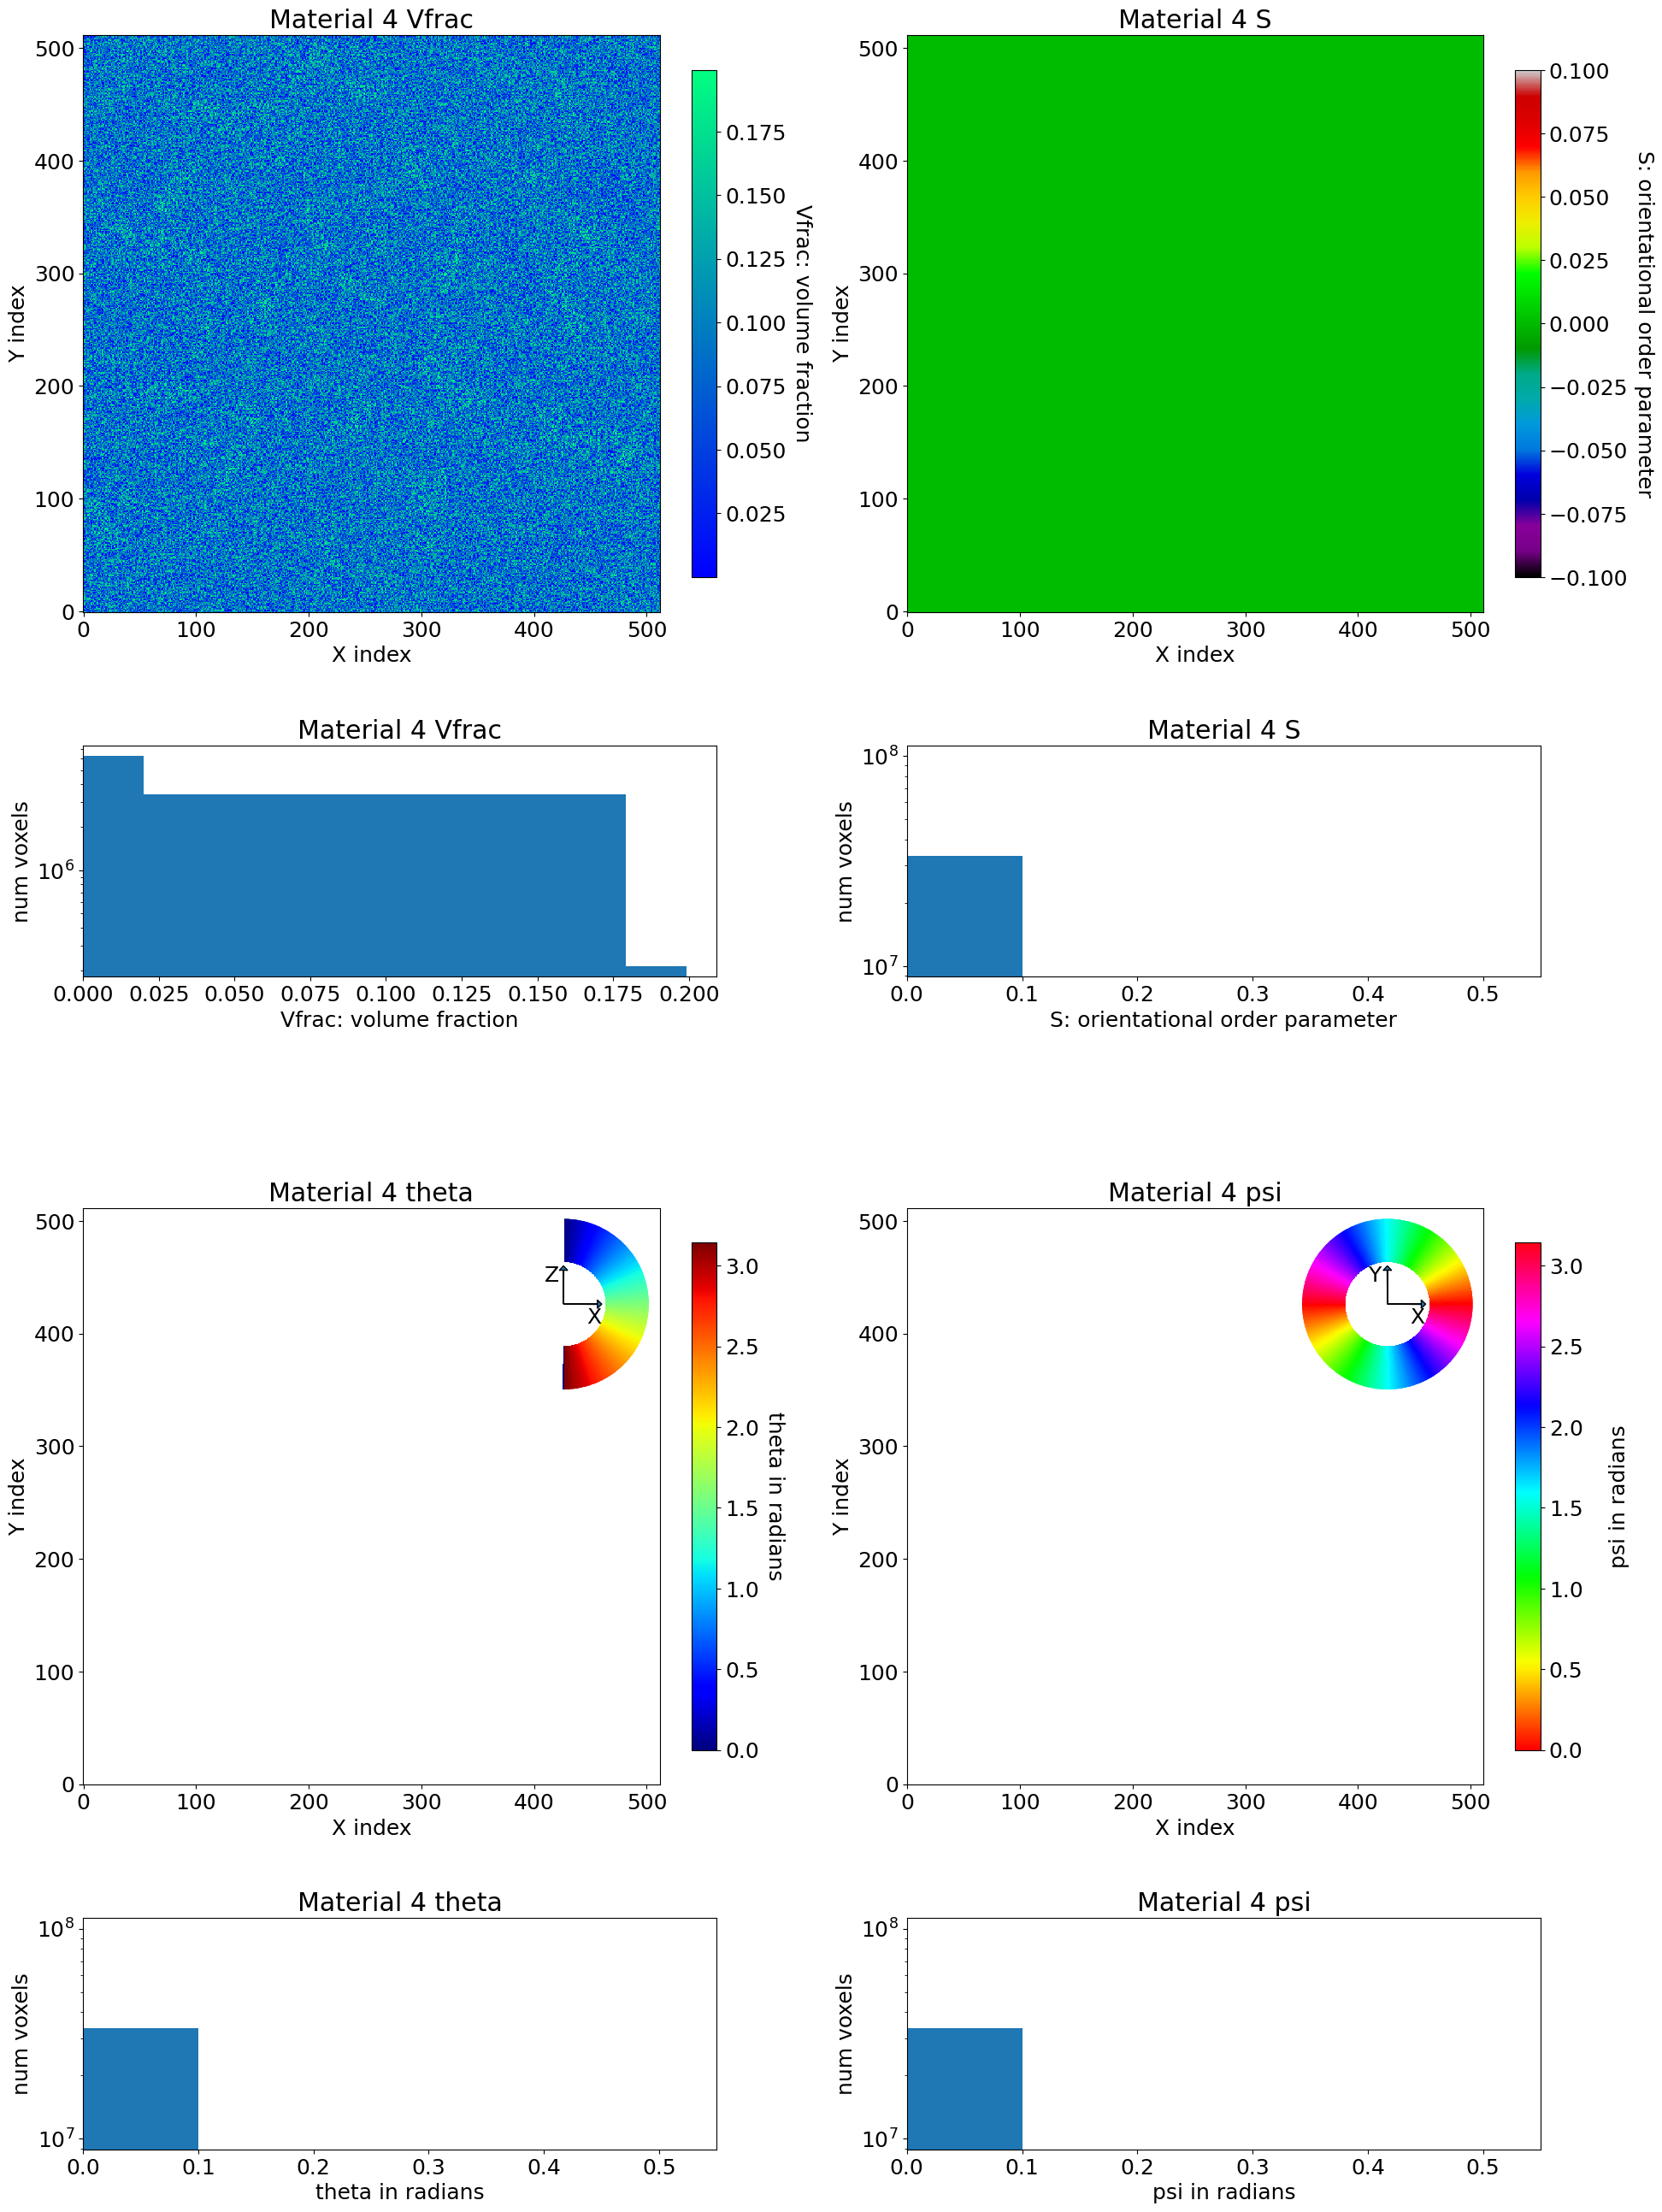

Total Vfrac whole model. Min: 0.9999999999999999 Max: 1.0
0:01:01.028326


In [46]:
checkH5('Fibril.hdf5', z_slice=55, plotstyle='light')

In [56]:
import pickle

# File I/O
pickle_save_name = 'C:/Users/Phong/Box/Research/Mixed Conduction Project/RSOXS Projects/Shared RSoXS Folder/NEXAFS/Quantum_ESPRESSO_HPC/PyHyperScattering_Batch_SST1_JupyterHub.pkl'
with open(pickle_save_name, 'rb') as file:
    data = pickle.load(file)

# Setup
data_dict = {'scan_ids': data[0], 'sample_names': data[1], 'edges': data[2], 'ARs': data[3], 'paras': data[4], 'perps': data[5], 'circs': data[6], 'FY_NEXAFSs': data[7], 'Iq2s': data[8], 'ISIs': data[9]}

In [57]:
# Edge you want to find
edge_to_find = 'C 1s'

# Finding the indices of the specified edge
indices = [index for index, edge in enumerate(data_dict['edges']) if edge == edge_to_find]

# Retrieving the corresponding 'energy' values from 'ARs'
energies = [data_dict['ARs'][index].energy for index in indices]

# # Print the energies
# for energy in energies:
#     print(energy)

In [58]:
energies = energies[0].values
energies

array([270.  , 272.  , 274.  , 276.  , 278.  , 280.  , 282.  , 282.25,
       282.5 , 282.75, 283.  , 283.25, 283.5 , 283.75, 284.  , 284.25,
       284.5 , 284.75, 285.  , 285.25, 285.5 , 285.75, 286.  , 286.5 ,
       287.  , 287.5 , 288.  , 288.5 , 289.  , 289.5 , 290.  , 290.5 ,
       291.  , 291.5 , 292.  , 293.  , 294.  , 295.  , 296.  , 297.  ,
       298.  , 299.  , 300.  , 301.  , 302.  , 303.  , 304.  , 305.  ,
       306.  , 310.  , 314.  , 318.  , 320.  , 330.  , 340.  ])

In [53]:
material_dict = {'Material1': 'vacuum', 
                 'Material2': 'C:/Users/Phong/Box/Research/Mixed Conduction Project/RSOXS Projects/Shared RSoXS Folder/CyRSoXS Processing/DopantModeling-main/xspectra_refractive_indices/P3HT_database_C_Kedge.txt', 
                 'Material3': 'C:/Users/Phong/Box/Research/Mixed Conduction Project/RSOXS Projects/Shared RSoXS Folder/CyRSoXS Processing/DopantModeling-main/xspectra_refractive_indices/P3HT_database_C_Kedge.txt',
                 'Material4': 'C:/Users/Phong/Box/Research/Mixed Conduction Project/RSOXS Projects/Shared RSoXS Folder/CyRSoXS Processing/DopantModeling-main/xspectra_refractive_indices/TFSI_2_C_Kedge.txt'}
energy_dict = {'Energy':6,'DeltaPerp':3, 'BetaPerp':1, 'DeltaPara':2, 'BetaPara':0}  
write_materials(energies, material_dict, energy_dict, 4)

In [54]:
write_config(list(energies), [1, 0, 0], CaseType=0, MorphologyType=0)

## Run CyRSoXS

In [54]:
subprocess.run(['CyRSoXS','Fibril.hdf5'])

[WARNING] : No value corresponding to HDF5DirName found. Setting to default
[WARNING] : No value corresponding to Algorithm found. Setting to default
[WARNING] : No value corresponding to MaxStreams found. Setting to default
Input Data : [OK] 
NumMaterial          : 3
Dimensions [Z Y X]   : [64 512 512]
PhysSize             : 2 nm 
E Rotation Angle     : 0 : 1 : 360
Morphology Type      : EulerAngles
Morphology Order     : ZYX
Energies simulated   : [280 280.5 281 281.5 282 282.5 283 283.5 284 284.5 285 285.5 286 286.2 286.4 286.6 286.8 287 287.2 287.4 287.6 287.8 288 288.5 289 289.5 290 290.5 291 291.5 292 292.5 293 293.5 294 294.5 ]
Windowing Type       : NONE
Rotation Mask        : 0
Interpolation Type   : Trilinear interpolation
HDF Output Directory : HDF5
Scatter Approach     : Partial
Algorithm            : CommunicationMinimizing
 __________________________________________________________________________________________________
|                                 Thanks for using 

CompletedProcess(args=['CyRSoXS', 'Fibril.hdf5'], returncode=0)

## Load CyRSoXS Results

In [55]:
basePath = pathlib.Path('.').absolute()
h5path = pathlib.Path(basePath,'HDF5')
h5list = list(sorted(h5path.glob('*h5')))

In [56]:
def print_key(f, key):
    try:
        keys2 = f[key].keys()
        for key2 in keys2:
            new_key = key + '/' + key2
            print_key(f, new_key)
    except AttributeError:
        print(key)

with h5py.File(h5list[0],'r') as f:
    for key in f.keys():
        print_key(f, key)

K0/projection
KIDList/KVec


In [57]:
load = cyrsoxsLoader()
integ = WPIntegrator(force_np_backend=True) # avoiding gpu backend for this tutorial

In [58]:
raw = load.loadDirectory(basePath)

Finished reading 36 energies. Time required: 0:00:00.033721


In [59]:
remeshed = integ.integrateImageStack(raw)

  0%|          | 0/36 [00:00<?, ?it/s]

## Visualize CyRSoXS Results

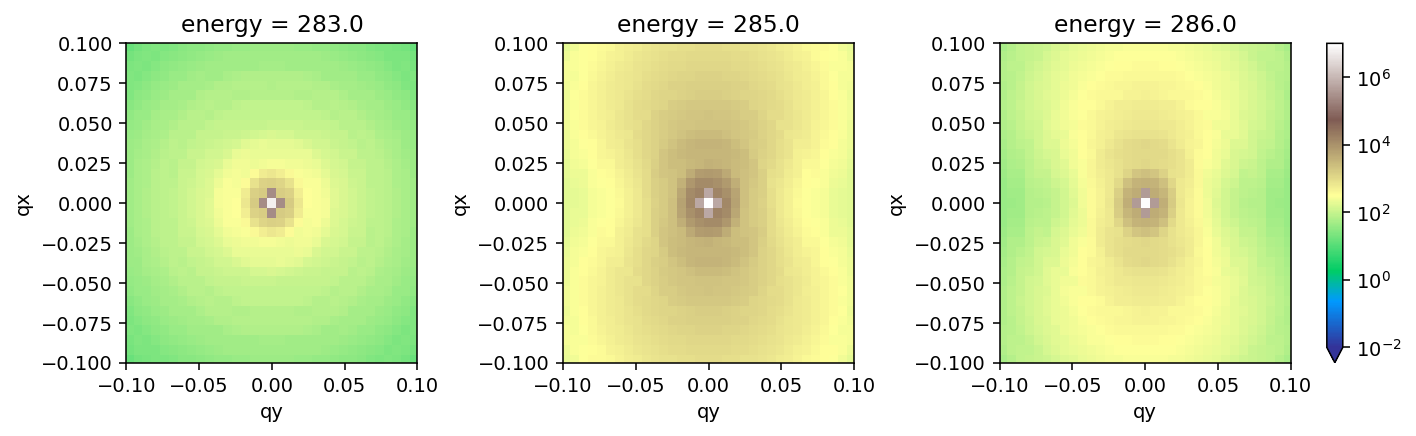

In [60]:
c = cm.jet(np.linspace(0,1,len(remeshed)))
fig, ax = plt.subplots(1,3,figsize=(10,3),dpi=140,constrained_layout=True)
raw.sel(energy=283).plot(norm=LogNorm(1e-2,1e7),cmap='terrain',ax=ax[0],add_colorbar=False)
raw.sel(energy=285).plot(norm=LogNorm(1e-2,1e7),cmap='terrain',ax=ax[1],add_colorbar=False)
raw.sel(energy=286).plot(norm=LogNorm(1e-2,1e7),cmap='terrain',ax=ax[2])

[{axes.set_xlim(-0.1,0.1),axes.set_ylim(-0.1,0.1)} for axes in ax]
plt.show()

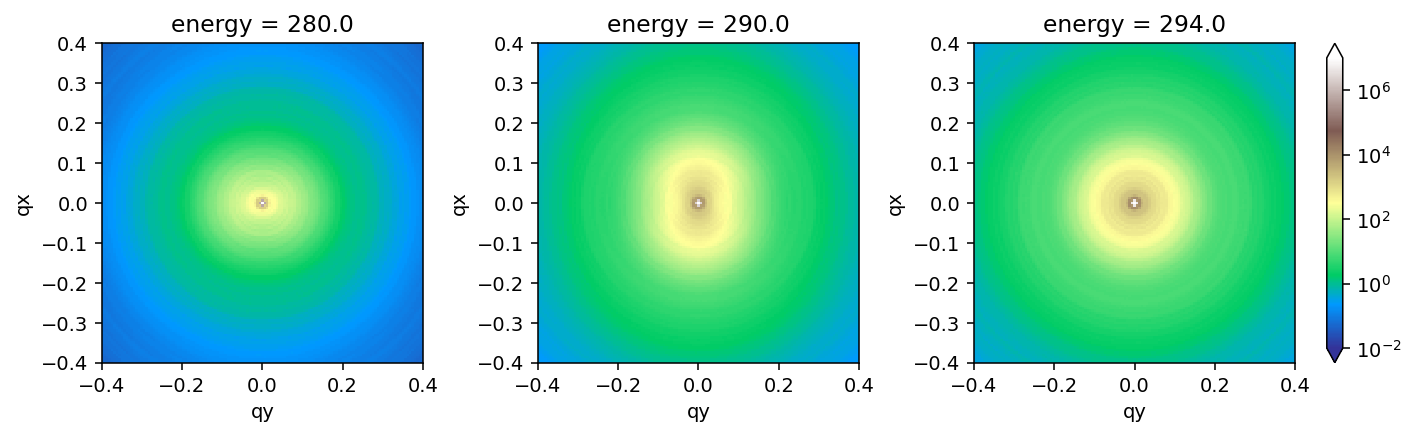

In [61]:
fig, ax = plt.subplots(1,3,figsize=(10,3),dpi=140,constrained_layout=True)
raw.sel(energy=280).plot(norm=LogNorm(1e-2,1e7),cmap='terrain',ax=ax[0],add_colorbar=False)
raw.sel(energy=290).plot(norm=LogNorm(1e-2,1e7),cmap='terrain',ax=ax[1],add_colorbar=False)
raw.sel(energy=294).plot(norm=LogNorm(1e-2,1e7),cmap='terrain',ax=ax[2])

[{axes.set_xlim(-0.4,0.4),axes.set_ylim(-0.4,0.4)} for axes in ax]
plt.show()

In [40]:
# calculate the anisotropy metric
A = remeshed.rsoxs.AR(chi_width=20)

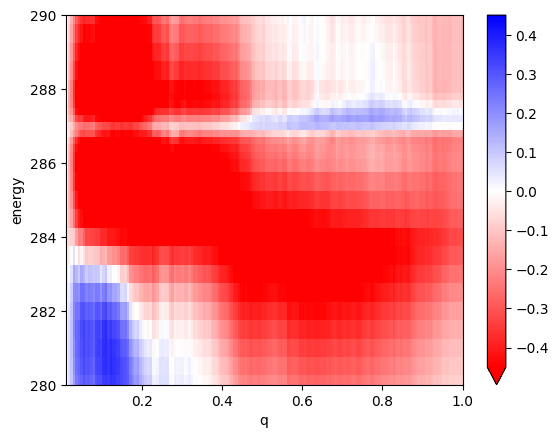

In [70]:
A.plot(x='q',cmap='bwr_r', vmin=-0.45, vmax=0.45)
plt.xlim(left=0.01, right=1)
plt.ylim(bottom=280, top=290)
plt.xscale('linear')
plt.show()

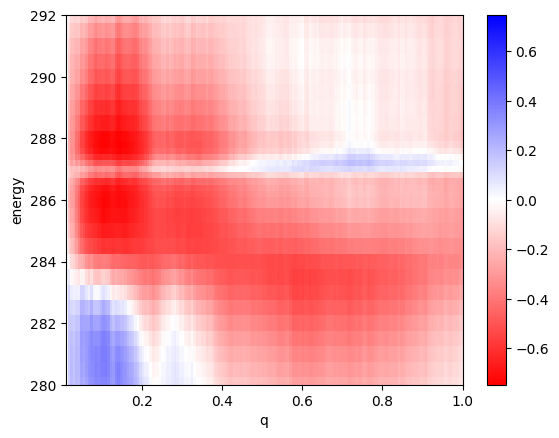

In [46]:
A.plot(x='q',cmap='bwr_r')
plt.xlim(left=0.01, right=1)
plt.ylim(bottom=280, top=290)
plt.xscale('linear')
plt.show()

In [26]:
horz = remeshed.rsoxs.slice_chi(0, chi_width=20)
vert = remeshed.rsoxs.slice_chi(90, chi_width=20)

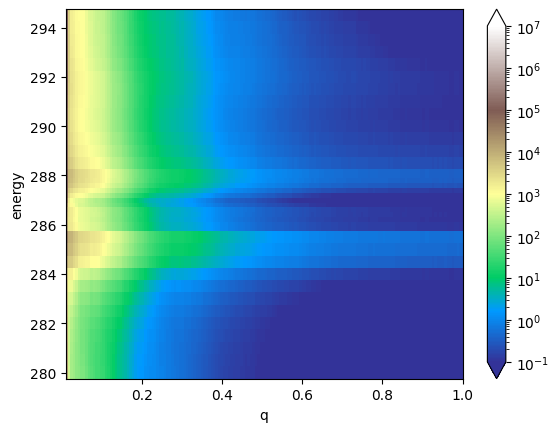

In [27]:
vert.plot(x='q',cmap='terrain',norm=LogNorm(1e-1,1e7), xscale='linear')
plt.xlim(left=0.01, right=1)
plt.show()

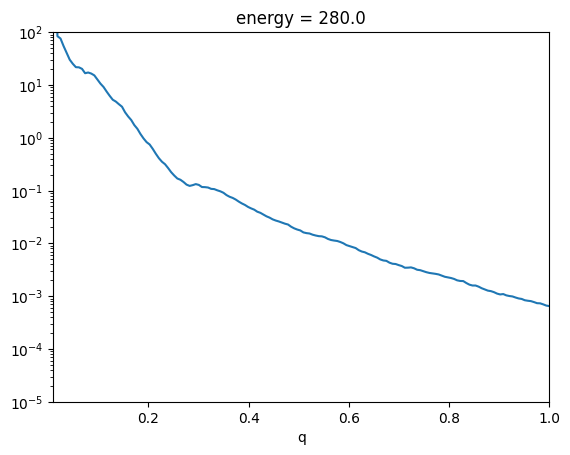

In [224]:
vert.sel(energy=280).plot(yscale='log',xscale='linear')
plt.xlim(left=0.01, right=1)
plt.ylim(bottom=1e-5, top=1e2)
plt.show()

# Visualize morphology:

In [54]:
def array2voxel(voxel_array):
    """
    convert a to a fixed size array to voxel_grid_index array
    (voxel_size*voxel_size*voxel_size)->(N*3)
    
    :input voxel_array: array with shape(voxel_size*voxel_size*voxel_size),the grid_index in 
    :return grid_index_array: get from o3d.voxel_grid.get_voxels()
    """
    x,y,z=np.where(voxel_array>0)
    voxel_mask = np.where(voxel_array>0)
    # x,y,z = voxel_mask
    valid_voxels = voxel_array[voxel_mask]
    index_voxel=np.vstack((x,y,z))
    grid_index_array=index_voxel.T
    return grid_index_array, valid_voxels

# frame = o3d.geometry.TriangleMesh.create_coordinate_frame(1)
voxel_array = mat_Vfrac[1]
# voxel_array = np.where(mat_Vfrac[0]<1,1,0)
grid_index_array, valid_voxels = array2voxel(voxel_array)
pointcloud_array=grid_index_array*0.03125#0.03125 is voxel_size
pc=o3d.geometry.PointCloud()
pc.points = o3d.utility.Vector3dVector(pointcloud_array)

color_max_array = np.array([[100], [100], [100]])
colors = np.dot(color_max_array, [valid_voxels]).T
pc.colors = o3d.utility.Vector3dVector(colors / 255.0)
print("pc created")

o3d_voxel=o3d.geometry.VoxelGrid.create_from_point_cloud(pc, voxel_size=0.03125)
print("Voxel created")
o3d.visualization.draw_geometries([o3d_voxel])

pc created
Voxel created


In [45]:
from pyvox.models import Vox
from pyvox.writer import VoxWriter
combmatFrac = mat_Vfrac[1]+mat_Vfrac[2]
voxmat = [[Vox.from_dense(np.ceil(combmatFrac[:,256*n:256*(n+1),256*m:256*(m+1)]).astype(int)) for n in range(2)] for m in range(2)]
[[VoxWriter(f'voxFile{a}x_{b}y.vox',voxmat[a][b]).write() for a in range(2)] for b in range(2)]

[[None, None], [None, None]]

In [5]:
from pyvox.models import Vox
from pyvox.writer import VoxWriter
fibMat = mat_Vfrac[1]
fibVox = [[Vox.from_dense(np.ceil(fibMat[:,256*n:256*(n+1),256*m:256*(m+1)]).astype(int)) for n in range(2)] for m in range(2)]
[[VoxWriter(f'FibvoxFile{a}x_{b}y.vox',fibVox[a][b]).write() for a in range(2)] for b in range(2)]
del fibVox
del fibMat
shellMat = np.where(mat_Vfrac[2]==1,1,0)
shellVox = [[Vox.from_dense(np.ceil(shellMat[:,256*n:256*(n+1),256*m:256*(m+1)]).astype(int)) for n in range(2)] for m in range(2)]
[[VoxWriter(f'ShellvoxFile{a}x_{b}y.vox',shellVox[a][b]).write() for a in range(2)] for b in range(2)]
del shellMat
del shellVox
matMat = np.where(mat_Vfrac[2]==0.9,1,0)
matVox = [[Vox.from_dense(np.ceil(matMat[:,256*n:256*(n+1),256*m:256*(m+1)]).astype(int)) for n in range(2)] for m in range(2)]
[[VoxWriter(f'MatvoxFile{a}x_{b}y.vox',matVox[a][b]).write() for a in range(2)] for b in range(2)]
del matMat
del matVox


In [57]:
import matplotlib as mpl
all_mats = (mat_Vfrac[1] + mat_Vfrac[2] + mat_Vfrac[3]).astype(bool)

height_map = np.zeros_like(all_mats[0,:,:],dtype=int)
for x in range(all_mats.shape[2]):
    for y in range(all_mats.shape[1]):
        # highest occupied index in z:
        height_map[y,x] = np.max(np.where(all_mats[:,y,x]))


([], [])

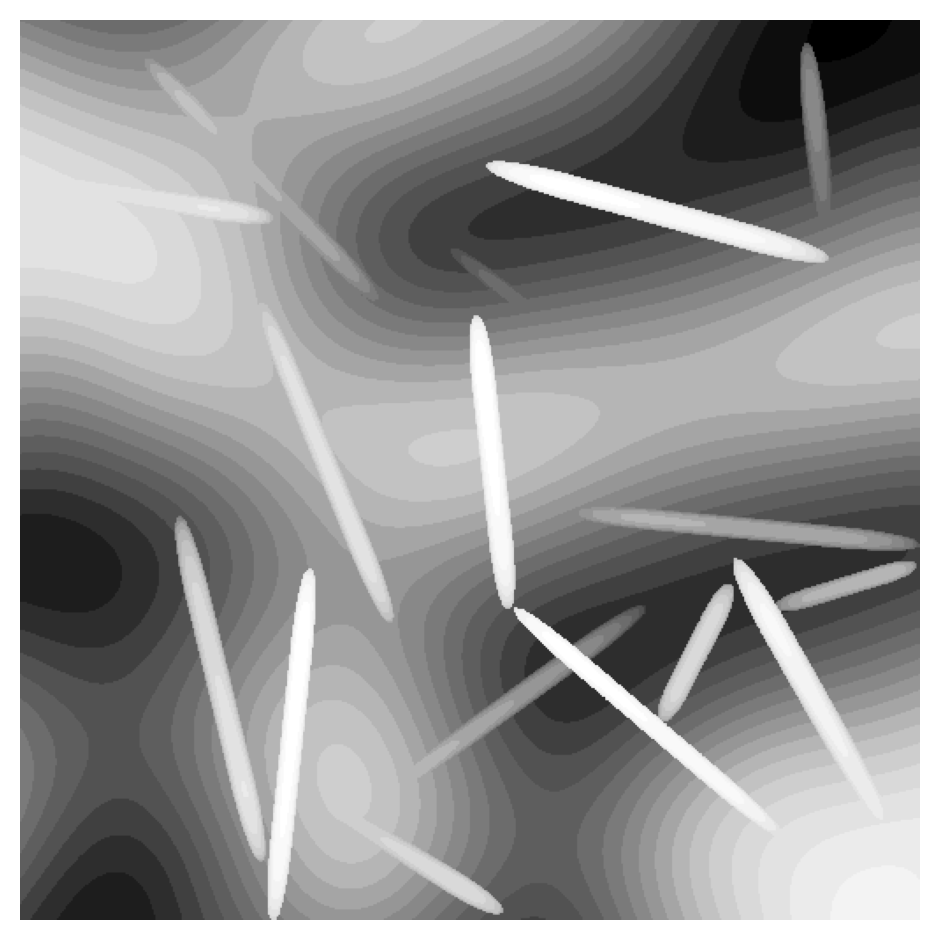

In [58]:

fig,ax = plt.subplots(dpi=200)
plt.axis('off')
plt.imshow(height_map, cmap = mpl.colormaps['Greys_r'])
fig.set_tight_layout(True)
# fig.s
plt.xticks([])
plt.yticks([])
# plt.colorbar()


In [ ]:
import pickle
import os
import sys
import shutil
import subprocess
import numpy as np

sys.path.append('/home/php/NRSS/')
sys.path.append('/home/php/DopantModeling/')

# Edge you want to find
edge_to_find = 'C 1s'
dopant_type = "TFSI_2"
dopant_case = "Dopant Everywhere"

# File I/O
pickle_save_name = '/home/php/CyRSoXS/PyHyperScattering_Batch_SST1_JupyterHub.pkl'
with open(pickle_save_name, 'rb') as file:
        data = pickle.load(file)

# Setup
data_dict = {'scan_ids': data[0], 'sample_names': data[1], 'edges': data[2], 'ARs': data[3], 'paras': data[4], 'perps': data[5], 'circs': data[6], 'FY_NEXAFSs': data[7], 'Iq2s': data[8], 'ISIs': data[9]}

# Finding the indices of the specified edge
indices = [index for index, edge in enumerate(data_dict['edges']) if edge == edge_to_find]

# Retrieving the corresponding 'energy' values from 'ARs'
energies = [data_dict['ARs'][index].energy for index in indices]

energies = energies[0].values[1:]

material_dict = {'Material1': 'vacuum', 
                'Material2': '/home/php/DopantModeling/xspectra_refractive_indices/P3HT_database_C_Kedge.txt', 
                'Material3': '/home/php/DopantModeling/xspectra_refractive_indices/P3HT_database_C_Kedge.txt',
                'Material4': '/home/php/DopantModeling/xspectra_refractive_indices/TFSI_2_C_Kedge.txt'}

energy_dict = {'Energy':6, 'DeltaPerp':3, 'BetaPerp':1, 'DeltaPara':2, 'BetaPara':0}  

VACUUM_ID  = 0 # Vacuum
CRYSTAL_ID = 1 # Crystalline P3HT
AMORPH_ID  = 2 # Amorphous P3HT
DOPANT_ID  = 3 # Dopant (optional)

mol_weight = {
    CRYSTAL_ID: 166.2842, # Molecular weight of crystalline P3HT
    AMORPH_ID: 166.2842,  # Molecular weight of amorphous P3HT
    DOPANT_ID: 280.14     # Molecular weight of TFSI- = 280.14, Molecular weight of F4TCNQ = 276.15
}

density = {
    CRYSTAL_ID: 1.1, # Density of crystalline P3HT
    AMORPH_ID: 1.1,  # Density of amorphous P3HT
    DOPANT_ID: 1.1   # Density of dopant in P3HT
}

from PostProcessing import generate_material_matricies
from NRSS.writer import write_materials, write_hdf5, write_config

def analyze_mol_fractions(mat_Vfrac, mol_weight=None, density=None):
    VACUUM_ID  = 0 # Vacuum
    CRYSTAL_ID = 1 # Crystalline P3HT
    AMORPH_ID  = 2 # Amorphous P3HT
    DOPANT_ID  = 3 # Dopant (optional)

    crystalline_volume = np.sum(mat_Vfrac[CRYSTAL_ID])
    amorphous_volume = np.sum(mat_Vfrac[AMORPH_ID])
    dopant_volume = 0
    dopant_moles = 0

    # Check if mat_Vfrac actually contains indices for the dopant
    if DOPANT_ID > len(mat_Vfrac):
        print("No dopant present")
    else:
        dopant_volume = np.sum(mat_Vfrac[DOPANT_ID])
        dopant_moles = (dopant_volume * density[DOPANT_ID]) / mol_weight[DOPANT_ID]

    # Calculate mole fractions
    crystalline_moles = (crystalline_volume * density[CRYSTAL_ID]) / mol_weight[CRYSTAL_ID]
    amorphous_moles = (amorphous_volume * density[AMORPH_ID]) / mol_weight[AMORPH_ID]
    
    total_moles = crystalline_moles + amorphous_moles + dopant_moles

    crystalline_mol_fraction = crystalline_moles / total_moles
    amorphous_mol_fraction = amorphous_moles / total_moles    
    dopant_mol_fraction = dopant_moles / total_moles if dopant_moles > 0 else 0

    print("Crystalline P3HT Mole Fraction:", crystalline_mol_fraction)
    print("Amorphous P3HT Mole Fraction:", amorphous_mol_fraction)
    print("Dopant Mole Fraction:", dopant_mol_fraction if dopant_moles > 0 else "No dopant present")

    return crystalline_mol_fraction, amorphous_mol_fraction, dopant_mol_fraction

def process_pickle_file(filename):
    print(f"Starting processing of pickle file: {filename}")

    hdf5_filename = os.path.splitext(filename)[0] + '.hdf5'
    description_filename = os.path.splitext(filename)[0] + '.txt'

    # Check if the corresponding .hdf5 file exists
    if not os.path.exists(hdf5_filename):
        print(f"Processing HDF5 file: {hdf5_filename}")
        with open(filename, 'rb') as f:
            rm = pickle.load(f)

        mat_Vfrac, mat_S, mat_theta, mat_psi = generate_material_matricies(rm)
        [crystalline_mol_fraction, amorphous_mol_fraction, dopant_mol_fraction] = analyze_mol_fractions(mat_Vfrac, mol_weight, density)

        with open(description_filename, 'w') as file:
            print(f"Writing description file: {description_filename}")
            file.write(f"Input file: {filename}\n")
            file.write(f"Crystalline P3HT Mole Fraction: {crystalline_mol_fraction}\n")
            file.write(f"Amorphous P3HT Mole Fraction: {amorphous_mol_fraction}\n")
            file.write(f"Dopant Mole Fraction: {dopant_mol_fraction}\n")
            file.write(f"Dopant Type: {dopant_type}\n")
            file.write(f"Dopant Case: {dopant_case}\n")

        max_index = len(mat_Vfrac)
        data_to_write = [[mat_Vfrac[i], mat_S[i], mat_theta[i], mat_psi[i]] for i in range(max_index)]
        phys_size = 2.0
        write_hdf5(data_to_write, phys_size, hdf5_filename)
        print(f"Wrote HDF5 file: {hdf5_filename}")
    else:
        print(f"{hdf5_filename} already exists, skipping generation...")

    if not os.path.exists(description_filename):
        with open(filename, 'rb') as f:
            rm = pickle.load(f)
        mat_Vfrac, _, _, _ = generate_material_matricies(rm)
        [crystalline_mol_fraction, amorphous_mol_fraction, dopant_mol_fraction] = analyze_mol_fractions(mat_Vfrac, mol_weight, density)

        with open(description_filename, 'w') as file:
            print(f"Writing description file: {description_filename}")
            file.write(f"Input file: {filename}\n")
            file.write(f"Crystalline P3HT Mole Fraction: {crystalline_mol_fraction}\n")
            file.write(f"Amorphous P3HT Mole Fraction: {amorphous_mol_fraction}\n")
            file.write(f"Dopant Mole Fraction: {dopant_mol_fraction}\n")
            file.write(f"Dopant Type: {dopant_type}\n")
            file.write(f"Dopant Case: {dopant_case}\n") 

    else:
        with open(description_filename, 'r') as file:
            description_content = file.read()
            print(description_content)

    write_materials(energies, material_dict, energy_dict, 4)
    write_config(list(energies), [0.0, 1.0, 360.0], CaseType=0, MorphologyType=0)
    print(f"Running CyRSoXS with file: {hdf5_filename}")
    subprocess.run(['CyRSoXS', hdf5_filename])

    print(f"Finished processing pickle file: {filename}")

# Gather a list of all .pickle files, excluding those in directories containing 'HDF5'
pickle_files = []
for root, dirs, files in os.walk('.'):
    for filename in files:
        if filename.endswith('.pickle') and 'HDF5' not in os.listdir(root):
            full_path = os.path.abspath(os.path.join(root, filename))
            pickle_files.append(full_path)

# Process the gathered .pickle files
for full_path in pickle_files:
    root, filename = os.path.split(full_path)
    print(f"Processing file: {filename}")

    base_filename = os.path.splitext(filename)[0]
    if os.path.basename(root) == base_filename:
        print(f"{filename} is already in a directory with a matching name")
        os.chdir(root)
        print(f"Changed working directory to: {root}")  # Fix here
        process_pickle_file(filename)
        continue

    new_directory = os.path.join(root, base_filename)
    os.makedirs(new_directory, exist_ok=True)
    print(f"Created directory: {new_directory}")
    new_path = os.path.abspath(os.path.join(new_directory, filename))
    shutil.move(full_path, new_path)
    print(f"Moved {filename} to {new_path}")

    os.chdir(new_directory)
    print(f"Changed working directory to: {new_directory}")
    process_pickle_file(filename)

In [68]:
energies[1:]

array([272.  , 274.  , 276.  , 278.  , 280.  , 282.  , 282.25, 282.5 ,
       282.75, 283.  , 283.25, 283.5 , 283.75, 284.  , 284.25, 284.5 ,
       284.75, 285.  , 285.25, 285.5 , 285.75, 286.  , 286.5 , 287.  ,
       287.5 , 288.  , 288.5 , 289.  , 289.5 , 290.  , 290.5 , 291.  ,
       291.5 , 292.  , 293.  , 294.  , 295.  , 296.  , 297.  , 298.  ,
       299.  , 300.  , 301.  , 302.  , 303.  , 304.  , 305.  , 306.  ,
       310.  , 314.  , 318.  , 320.  , 330.  , 340.  ])

In [ ]:
    def plot_fibril_histogram(self):
        # Extracting lengths, radii, orientations theta, and orientations psi from fibrils
        lengths = [fibril.length for fibril in self.fibrils]
        radii = [fibril.radius for fibril in self.fibrils]
        orientation_thetas = [fibril.orientation_theta for fibril in self.fibrils]
        orientation_psis = [fibril.orientation_psi for fibril in self.fibrils]

        # Creating a histogram for lengths
        plt.figure(figsize=(18, 10))

        plt.subplot(2, 2, 1)
        plt.hist(lengths, bins=20, edgecolor='black')
        plt.title('Histogram of Fibril Lengths')
        plt.xlabel('Length')
        plt.ylabel('Frequency')

        # Creating a histogram for radii
        plt.subplot(2, 2, 2)
        plt.hist(radii, bins=20, edgecolor='black')
        plt.title('Histogram of Fibril Radii')
        plt.xlabel('Radius')
        plt.ylabel('Frequency')

        # Creating a plot for orientation theta
        plt.subplot(2, 2, 3)
        plt.hist(orientation_thetas, bins=20, edgecolor='black')
        plt.title('Histogram of Orientation Theta')
        plt.xlabel('Theta')
        plt.ylabel('Frequency')

        # Creating a plot for orientation psi
        plt.subplot(2, 2, 4)
        plt.hist(orientation_psis, bins=20, edgecolor='black')
        plt.title('Histogram of Orientation Psi')
        plt.xlabel('Psi')
        plt.ylabel('Frequency')

        plt.tight_layout()
        plt.show()